## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
%load_ext autoreload
%autoreload 2

import IPython
import sys
import os
import random
import time
from dataclasses import dataclass
from enum import Enum
import itertools

import math
import statistics
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch import optim
from torchvision import transforms
from torchinfo import summary

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
import h5py
import tifffile
import tqdm




### <font style="color:lightblue">Functions</font>

In [2]:


def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)


def plotData(dataY, rangeY=None, dataYR=None, rangeYR=None,
             dataX=None, rangeX=None, rangeP=None,
             figsize=(16,8), saveTo=None, show=True):

    if type(dataY) is np.ndarray :
        plotData((dataY,), rangeY=rangeY, dataYR=dataYR, rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataYR) is np.ndarray :
        plotData(dataY, rangeY=rangeY, dataYR=(dataYR,), rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataY) is not tuple :
        eprint(f"Unknown data type to plot: {type(dataY)}.")
        return
    if type(dataYR) is not tuple and dataYR is not None:
        eprint(f"Unknown data type to plot: {type(dataYR)}.")
        return

    last = min( len(data) for data in dataY )
    if dataYR is not None:
        last = min( last,  min( len(data) for data in dataYR ) )
    if dataX is not None:
        last = min(last, len(dataX))
    if rangeP is None :
        rangeP = (0,last)
    elif type(rangeP) is int :
        rangeP = (0,rangeP) if rangeP > 0 else (-rangeP,last)
    elif type(rangeP) is tuple :
        rangeP = ( 0    if rangeP[0] is None else rangeP[0],
                   last if rangeP[1] is None else rangeP[1],)
    else :
        eprint(f"Bad data type on plotData input rangeP: {type(rangeP)}")
        raise Exception(f"Bug in the code.")
    rangeP = np.s_[ max(0, rangeP[0]) : min(last, rangeP[1]) ]
    if dataX is None :
        dataX = np.arange(rangeP.start, rangeP.stop)

    plt.style.use('default')
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.xaxis.grid(True, 'both', linestyle='dotted')
    if rangeX is not None :
        ax1.set_xlim(rangeX)
    else :
        ax1.set_xlim(rangeP.start,rangeP.stop-1)

    ax1.yaxis.grid(True, 'both', linestyle='dotted')
    nofPlots = len(dataY)
    if rangeY is not None:
        ax1.set_ylim(rangeY)
    colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
    for idx , data in enumerate(dataY):
        ax1.plot(dataX, data[rangeP], linestyle='-',  color=colors[idx])

    if dataYR is not None : # right Y axis
        ax2 = ax1.twinx()
        ax2.yaxis.grid(True, 'both', linestyle='dotted')
        nofPlots = len(dataYR)
        if rangeYR is not None:
            ax2.set_ylim(rangeYR)
        colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
        for idx , data in enumerate(dataYR):
            ax2.plot(dataX, data[rangeP], linestyle='dashed',  color=colors[idx])

    if saveTo:
        fig.savefig(saveTo)
    if not show:
        plt.close(fig)


def plotImage(image) :
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.show()


def plotImages(images) :
    for i, img in enumerate(images) :
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis("off")
    plt.show()


def sliceShape(shape, sl) :
    if type(shape) is int :
        shape = torch.Size([shape])
    if type(sl) is tuple :
        if len(shape) != len(sl) :
            raise Exception(f"Different sizes of shape {shape} and sl {sl}")
        out = []
        for i in range(0, len(shape)) :
            indeces = sl[i].indices(shape[i])
            out.append(indeces[1]-indeces[0])
        return out
    elif type(sl) is slice :
        indeces = sl.indices(shape[0])
        return indeces[1]-indeces[0]
    else :
        raise Exception(f"Incompatible object {sl}")


def tensorStat(stat) :
    print(f"{stat.mean().item():.3e}, {stat.std().item():.3e}, "
          f"{stat.min().item():.3e}, {stat.max().item():.3e}")


def fillWheights(seq) :
    for wh in seq :
        if hasattr(wh, 'weight') :
            torch.nn.init.xavier_uniform_(wh.weight)
            #torch.nn.init.zeros_(wh.weight)
            #torch.nn.init.constant_(wh.weight, 0)
            #torch.nn.init.uniform_(wh.weight, a=0.0, b=1.0, generator=None)
            #torch.nn.init.normal_(wh.weight, mean=0.0, std=0.01)


def unsqeeze4dim(tens):
    orgDims = tens.dim()
    if tens.dim() == 2 :
        tens = tens.unsqueeze(0)
    if tens.dim() == 3 :
        tens = tens.unsqueeze(1)
    return tens, orgDims


def squeezeOrg(tens, orgDims):
    if orgDims == tens.dim():
        return tens
    if tens.dim() != 4 or orgDims > 4 or orgDims < 2:
        raise Exception(f"Unexpected dimensions to squeeze: {tens.dim()} {orgDims}.")
    if orgDims < 4 :
        if tens.shape[1] > 1:
            raise Exception(f"Cant squeeze dimension 1 in: {tens.shape}.")
        tens = tens.squeeze(1)
    if orgDims < 3 :
        if tens.shape[0] > 1:
            raise Exception(f"Cant squeeze dimension 0 in: {tens.shape}.")
        tens = tens.squeeze(0)
    return tens


### <font style="color:lightblue">Configs</font>

In [3]:
def set_seed(SEED_VALUE):
    torch.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    np.random.seed(SEED_VALUE)

seed = 7
set_seed(seed)

@dataclass(frozen=True)
class TCfg:
    exec = 1
    device: torch.device = f"cuda:{exec}"
    nofEpochs: int = 2048
    latentDim: int = 64
    batchSize: int = 512
    labelSmoothFac: float = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    learningRateD: float = 0.00002
    learningRateG: float = 0.00002
    historyHDF = f"train_{exec}.hdf"

class DCfg:
    gapW = 16
    sinoSh = (5*gapW,5*gapW) # 80x80
    readSh = (80, 80)
    sinoSize = math.prod(sinoSh)
    gapSh = (sinoSh[0],gapW)
    gapSize = math.prod(gapSh)
    gapRngX = np.s_[ sinoSh[1]//2 - gapW//2 : sinoSh[1]//2 + gapW//2 ]
    gapRng = np.s_[ : , gapRngX ]
    disRng = np.s_[ gapW:-gapW , gapRngX ]




### <font style="color:lightblue">Save/Load</font>

In [4]:
def save_model(model, device, model_path):
    if not device == 'cpu':
        model.to('cpu')
    torch.save(model.state_dict(), model_path)
    if not device == 'cpu':
        model.to(device)
    return


def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    return model


def saveCheckPoint(path, epoch, minGEpoch, minGdLoss,
                   generator, discriminator,
                   optimizerGen=None, optimizerDis=None,
                   schedulerGen=None, schedulerDis=None,
                   device=None ) :
    generator.to('cpu')
    discriminator.to('cpu')
    checkPoint = {}
    checkPoint['epoch'] = epoch
    checkPoint['minGEpoch'] = minGEpoch
    checkPoint['minGdLoss'] = minGdLoss
    checkPoint['generator'] = generator.state_dict()
    checkPoint['discriminator'] = discriminator.state_dict()
    if not optimizerGen is None :
        checkPoint['optimizerGen'] = optimizerGen.state_dict()
    if not schedulerGen is None :
        checkPoint['schedulerGen'] = schedulerGen.state_dict()
    if not optimizerDis is None :
        checkPoint['optimizerDis'] = optimizerDis.state_dict()
    if not schedulerDis is None :
        checkPoint['schedulerDis'] = schedulerDis.state_dict()
    torch.save(checkPoint, path)
    if not device is None:
        generator.to(device)
        discriminator.to(device)


def loadCheckPoint(path, generator, discriminator,
                   optimizerGen=None, optimizerDis=None,
                   schedulerGen=None, schedulerDis=None,
                   device=None ) :
    checkPoint = torch.load(path)
    epoch = checkPoint['epoch']
    minGEpoch = checkPoint['minGEpoch']
    minGdLoss = checkPoint['minGdLoss']
    generator.load_state_dict(checkPoint['generator'])
    discriminator.load_state_dict(checkPoint['discriminator'])
    if not device is None :
        generator.to(device)
        discriminator.to(device)
    if not optimizerGen is None :
        optimizerGen.load_state_dict(checkPoint['optimizerGen'])
    if not schedulerGen is None :
        schedulerGen.load_state_dict(checkPoint['schedulerGen'])
    if not optimizerDis is None :
        optimizerDis.load_state_dict(checkPoint['optimizerDis'])
    if not schedulerDis is None :
        schedulerDis.load_state_dict(checkPoint['schedulerDis'])
    return epoch, minGEpoch, minGdLoss


def addToHDF(filename, containername, data) :
    if len(data.shape) == 2 :
        data=np.expand_dims(data, 0)
    if len(data.shape) != 3 :
        raise Exception(f"Not appropriate input array size {data.shape}.")

    with h5py.File(filename,'a') as file :

        if  containername not in file.keys():
            dset = file.create_dataset(containername, data.shape,
                                       maxshape=(None,data.shape[1],data.shape[2]),
                                       dtype='f')
            dset[()] = data
            return

        dset = file[containername]
        csh = dset.shape
        if csh[1] != data.shape[1] or csh[2] != data.shape[2] :
            raise Exception(f"Shape mismatch: input {data.shape}, file {dset.shape}.")
        msh = dset.maxshape
        newLen = csh[0] + data.shape[0]
        if msh[0] is None or msh[0] >= newLen :
            dset.resize(newLen, axis=0)
        else :
            raise Exception(f"Insufficient maximum shape {msh} to add data"
                            f" {data.shape} to current volume {dset.shape}.")
        dset[csh[0]:newLen,...] = data
        file.close()


    return 0

## <font style="color:lightblue">Data</font>

### <font style="color:lightblue">Raw Read</font>

In [5]:

class StripesFromHDF :

    def __init__(self, sampleName, maskName, bgName=None, dfName=None, loadToMem=True):

        sampleHDF = sampleName.split(':')
        if len(sampleHDF) != 2 :
            raise Exception(f"String \"{sampleName}\" does not represent an HDF5 format.")
        with h5py.File(sampleHDF[0],'r') as trgH5F:
            if  sampleHDF[1] not in trgH5F.keys():
                raise Exception(f"No dataset '{sampleHDF[1]}' in input file {sampleHDF[0]}.")
            self.data = trgH5F[sampleHDF[1]]
            if not self.data.size :
                raise Exception(f"Container \"{sampleName}\" is zero size.")
            self.sh = self.data.shape
            if len(self.sh) != 3 :
                raise Exception(f"Dimensions of the container \"{sampleName}\" is not 3 {self.sh}.")
            self.fsh = self.sh[1:3]
            self.volume = None
            if loadToMem :
                self.volume = np.empty(self.sh, dtype=np.float32)
                self.data.read_direct(self.volume)
                trgH5F.close()

            def loadImage(imageName) :
                if not imageName:
                    return None
                imdata = imread(imageName).astype(np.float32)
                if len(imdata.shape) == 3 :
                    imdata = np.mean(imdata[:,:,0:3], 2)
                if imdata.shape != self.fsh :
                    raise Exception(f"Dimensions of the input image \"{imageName}\" {imdata.shape} "
                                    f"do not match the face of the container \"{sampleName}\" {self.fsh}.")
                return imdata

            self.mask = loadImage(maskName)
            if self.mask is None :
                self.mask = np.ones(self.fsh, dtype=np.uint8)
            self.mask = self.mask.astype(bool)
            self.bg = loadImage(bgName)
            self.df = loadImage(dfName)
            if self.bg is not None :
                if self.df is not None:
                    self.bg -= self.df
                self.mask  &=  self.bg > 0.0

            self.allIndices = []
            for yCr in range(0,self.fsh[0]) :
                for xCr in range(0,self.fsh[1]) :
                    idx = np.s_[yCr,xCr]
                    if self.mask[idx] :
                        if self.volume is not None :
                            if self.df is not None :
                                self.volume[:,*idx] -= self.df[idx]
                            if self.bg is not None :
                                self.volume[:,*idx] /= self.bg[idx]
                        if  xCr + DCfg.readSh[1] < self.fsh[1] \
                        and np.all( self.mask[yCr,xCr+1:xCr+DCfg.readSh[1]] ) :
                            self.allIndices.append(idx)

    def get_dataset(self, transform=None) :

        class Sinos(torch.utils.data.Dataset) :

            def __init__(self, root, transform=None):
                self.container = root
                self.transform = transforms.Compose([transforms.ToTensor(), transform]) \
                    if transform else transforms.ToTensor()

            def __len__(self):
                return len(self.container.allIndices)

            def __getitem__(self, index, idxs=None):
                if idxs is None :
                    idxs = random.randint(0,self.container.sh[0]-DCfg.readSh[0]-1)
                    index = random.randint(0,len(self.container.allIndices)-1)
                idx = self.container.allIndices[index]
                xyrng=np.s_[ idx[0], idx[1]:idx[1]+DCfg.readSh[1] ]
                if self.container.volume is not None :
                    data = self.container.volume[idxs:idxs+DCfg.readSh[0], *xyrng]
                else :
                    data = self.container.data[idxs:idxs+DCfg.readSh[0], *xyrng]
                    if self.container.df is not None :
                        data -= self.container.df[None,*xyrng]
                    if self.container.bg is not None :
                        data /= self.container.bg[None,*xyrng]
                if self.transform :
                    data = self.transform(data)
                return (data, index, idxs)

        return Sinos(self, transform)



class StripesFromHDFs :
    def __init__(self, bases):
        self.collection = []
        for base in bases :
            self.collection.append(
                StripesFromHDF(f"storage/{base}.hdf:/data", f"storage/{base}.mask.tif", None, None) )
            print("Loaded set " + base)

    def get_dataset(self, transform=None) :

        class Sinos(torch.utils.data.Dataset) :

            def __init__(self, root, transform=None):
                self.container = root
                self.transform = transforms.Compose([transforms.ToTensor(), transform]) \
                    if transform else transforms.ToTensor()

            def __len__(self):
                return sum( [ len(set.allIndices) for set in self.container.collection ] )

            def __getitem__(self, index, idxs=None):
                if idxs is None :
                    index = random.randint(0,len(self)-1)
                leftover = index
                useset = None
                for set in self.container.collection :
                    setLen = len(set.allIndices)
                    if leftover >= setLen :
                        leftover -= setLen
                    else :
                        useset = set
                        break
                if useset is None :
                    raise f"No set for index {index}."
                if idxs is None :
                    idxs = random.randint(0,useset.sh[0]-DCfg.readSh[0]-1)
                idx = useset.allIndices[leftover]
                xyrng=np.s_[ idx[0], idx[1]:idx[1]+DCfg.readSh[1] ]
                if useset.volume is not None :
                    data = useset.volume[idxs:idxs+DCfg.readSh[0], *xyrng]
                else :
                    data = useset.data[idxs:idxs+DCfg.readSh[0], *xyrng]
                    if useset.df is not None :
                        data -= useset.df[None,*xyrng]
                    if useset.bg is not None :
                        data /= useset.bg[None,*xyrng]
                if self.transform :
                    data = self.transform(data)
                return (data, index, idxs)

        return Sinos(self, transform)

examples = {}

#baseName = "4176862R_Eig_Threshold-4keV"
#examples[2] = (1271101, 570) # (229247,541)
#examples[4] = (962537,512) # (112073,759)  (129198, 800)

#baseName = "18515.Lamb1_Eiger_7m_45keV_360Scan"
#examples[2] = (171308, 848) # (34008,1620)
#examples[4] = (27643, 240)

#baseName = "21987.70keV_7m_Eiger_Calf3"
#examples[2] =

#sinoRoot = StripesFromHDF(f"storage/{baseName}.hdf:/data", f"storage/{baseName}.mask.tif",None, None)
sinoRoot = StripesFromHDFs( [ "4176862R_Eig_Threshold-4keV",
                              "18515.Lamb1_Eiger_7m_45keV_360Scan",
                              "23574.8965435L.Eiger.32kev_org" ,
                              "23574.8965435L.Eiger.32kev_sft"
                             ]  )
examples[4] = (94865, 840) # (974214, 631) #
examples[8] = (436179, 70)
examples[16] = (1958164,1391) # (863470, 620)
dataTransform =  transforms.Compose([
    transforms.Resize(DCfg.sinoSh),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=(0.5), std=(1))
])
trainSet = sinoRoot.get_dataset(dataTransform)
prepGdLoss=0




Loaded set 4176862R_Eig_Threshold-4keV
Loaded set 18515.Lamb1_Eiger_7m_45keV_360Scan
Loaded set 23574.8965435L.Eiger.32kev_org
Loaded set 23574.8965435L.Eiger.32kev_sft


### <font style="color:lightblue">Show</font>

-3.485e-01, 1.767e-02, -4.022e-01, -2.940e-01


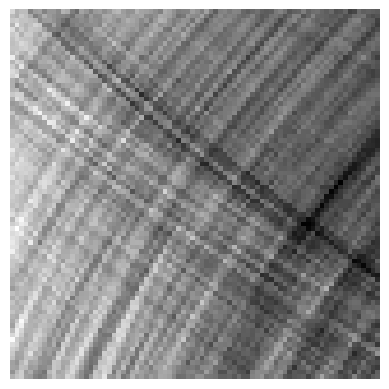

In [6]:
refImages = None
refNoises = None

def showMe() :
    global refImages, refNoises
    image = None
    #if False :
    if True :
        #image, _,_ = trainSet.__getitem__(*examples[DCfg.gapW])
        image, _,_ = trainSet.__getitem__(1958164,1391)
    else :
        while True:
            image, index, idxs = trainSet[random.randint(0,len(trainSet)-1)]
            if image.mean() > 0 and image.min() < -0.1 :
                print (f"{index}, {idxs}")
                break
    image = image.squeeze()
    tensorStat(image)
    plotImage(image)
    image = image.to(TCfg.device)
    refImages = torch.stack((image,image)).to(TCfg.device)
    refNoises = torch.randn((2,TCfg.latentDim)).to(TCfg.device)

showMe()


## <font style="color:lightblue">Models</font>

### <font style="color:lightblue">Lower resolution generators</font>

#### <font style="color:lightblue">Two pixels gap</font>

In [ ]:


class Generator2(nn.Module):

    def __init__(self):
        super(Generator2, self).__init__()

        self.gapW = 2
        self.sinoSh = (5*self.gapW,5*self.gapW) # 10,10
        self.sinoSize = math.prod(self.sinoSh)
        self.gapSh = (self.sinoSh[0],self.gapW)
        self.gapSize = math.prod(self.gapSh)
        self.gapRngX = np.s_[ self.sinoSh[1]//2 - self.gapW//2 : self.sinoSh[1]//2 + self.gapW//2 ]
        self.gapRng = np.s_[ : , self.gapRngX ]

        latentChannels = 7
        self.noise2latent = nn.Sequential(
            nn.Linear(TCfg.latentDim, self.sinoSize*latentChannels),
            nn.ReLU(),
            nn.Unflatten( 1, (latentChannels,) + self.sinoSh )
        )
        fillWheights(self.noise2latent)

        baseChannels = 64

        self.encode = nn.Sequential(

            nn.Conv2d(latentChannels+1, baseChannels, 3),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, baseChannels, 3),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, baseChannels, 3),
            nn.LeakyReLU(0.2),

        )
        fillWheights(self.encode)

        encSh = self.encode(torch.zeros((1,latentChannels+1,*self.sinoSh))).shape
        linChannels = math.prod(encSh)
        self.link = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, encSh[1:]),
        )
        fillWheights(self.link)


        self.decode = nn.Sequential(

            nn.ConvTranspose2d(baseChannels, baseChannels, (3,1)),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(baseChannels, baseChannels, (3,1)),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(baseChannels, baseChannels, (3,1)),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, 1, (1,3)),
            nn.Tanh()

        )
        fillWheights(self.decode)


        self.body = nn.Sequential(
            self.encode,
            self.link,
            self.decode
        )


    def forward(self, input):
        images, noises = input
        images, orgDims = unsqeeze4dim(images)
        latent = self.noise2latent(noises)
        modelIn = torch.cat((images,latent),dim=1)
        mIn = modelIn[:,0,*self.gapRng]
        mIn[()] = self.preProc(images[:,0,:,:])
        patches = self.body(modelIn)
        mIn = mIn.unsqueeze(1)
        #patches = mIn + torch.where( patches < 0 , patches * mIn , patches ) # no normalization
        patches = mIn + patches * torch.where( patches < 0 , mIn+0.5 , 1 ) # normalization
        return squeezeOrg(patches, orgDims)


    def preProc(self, images) :
        images = images.unsqueeze(0) # for the 2D case
        res = torch.zeros(images[...,*self.gapRng].shape, device=images.device)
        res[...,0] += 2*images[...,self.gapRngX.start-1] + images[...,self.gapRngX.stop]
        res[...,1] += 2*images[...,self.gapRngX.stop] + images[...,self.gapRngX.start-1]
        res = res.squeeze(0) # to compensate for the first squeeze
        return res/3

    def generatePatches(self, images, noises=None) :
        if noises is None :
            noises = torch.randn( 1 if images.dim() < 3 else images.shape[0], TCfg.latentDim).to(TCfg.device)
        return self.forward((images,noises))


    def fillImages(self, images, noises=None) :
        images[...,*self.gapRng] = self.generatePatches(images, noises)
        return images


    def generateImages(self, images, noises=None) :
        clone = images.clone()
        return self.fillImages(clone, noises)


generator2 = Generator2()
generator2 = load_model(generator2, model_path="saves/gap16/vanila/gap2_cor.model_gen.pt" )
generator2.to(TCfg.device)
generator2.requires_grad_(False)
generator2.eval()
#model_summary = summary(generator2, input_data=[ [refImages, refNoises] ] ).__str__()
#print(model_summary)




/tmp/ipykernel_28546/3985860939.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Generator2(
  (noise2latent): Sequential(
    (0): Linear(in_features=64, out_features=700, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(7, 10, 10))
  )
  (encode): Sequential(
    (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
  )
  (link): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Unflatten(dim=1, unflattened_size=torch.Size([64, 4, 4]))
  )
  (decode): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 1), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): ConvTranspose2d

#### <font style="color:lightblue">Four pixels gap</font>

In [ ]:


class Generator4(nn.Module):

    def __init__(self):
        super(Generator4, self).__init__()

        self.gapW = 4
        self.sinoSh = (5*self.gapW,5*self.gapW) # 20,20
        self.sinoSize = math.prod(self.sinoSh)
        self.gapSh = (self.sinoSh[0],self.gapW)
        self.gapSize = math.prod(self.gapSh)
        self.gapRngX = np.s_[ self.sinoSh[1]//2 - self.gapW//2 : self.sinoSh[1]//2 + self.gapW//2 ]
        self.gapRng = np.s_[ : , self.gapRngX ]

        latentChannels = 7
        self.noise2latent = nn.Sequential(
            nn.Linear(TCfg.latentDim, self.sinoSize*latentChannels),
            nn.ReLU(),
            nn.Unflatten( 1, (latentChannels,) + self.sinoSh )
        )
        fillWheights(self.noise2latent)

        baseChannels = 128

        self.encode = nn.Sequential(

            nn.Conv2d(latentChannels+1, baseChannels, 3),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, baseChannels, 3, stride=2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, baseChannels, 3),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, baseChannels, 3),
            nn.LeakyReLU(0.2),

        )
        fillWheights(self.encode)


        encSh = self.encode(torch.zeros((1,latentChannels+1,*self.sinoSh))).shape
        linChannels = math.prod(encSh)
        self.link = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, encSh[1:]),
        )
        fillWheights(self.link)


        self.decode = nn.Sequential(

            nn.ConvTranspose2d(baseChannels, baseChannels, (3,1)),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(baseChannels, baseChannels, (3,1)),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(baseChannels, baseChannels, (4,1), stride=(2,1)),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(baseChannels, baseChannels, (3,1)),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, 1, 1),
            nn.Tanh()

        )
        fillWheights(self.decode)


        self.body = nn.Sequential(
            self.encode,
            self.link,
            self.decode
        )


    def forward(self, input):
        images, noises = input
        images, orgDims = unsqeeze4dim(images)
        latent = self.noise2latent(noises)
        modelIn = torch.cat((images,latent),dim=1)
        mIn = modelIn[:,0,*self.gapRng]
        mIn[()] = self.preProc(images[:,0,:,:])
        patches = self.body(modelIn)
        mIn = mIn.unsqueeze(1)
        #patches = mIn + torch.where( patches < 0 , patches * mIn , patches ) # no normalization
        patches = mIn + patches * torch.where( patches < 0 , mIn+0.5 , 1 ) # normalization
        return squeezeOrg(patches, orgDims)


    def preProc(self, images) :
        images, orgDims = unsqeeze4dim(images)
        preImages = torch.nn.functional.interpolate(images, scale_factor=0.5, mode='area')
        prePatches = generator2.generatePatches(preImages)
        prePatches = torch.nn.functional.interpolate(prePatches, scale_factor=2, mode='bilinear')
        return squeezeOrg(prePatches, orgDims)


    def generatePatches(self, images, noises=None) :
        if noises is None :
            noises = torch.randn( 1 if images.dim() < 3 else images.shape[0], TCfg.latentDim).to(TCfg.device)
        return self.forward((images,noises))


    def fillImages(self, images, noises=None) :
        images[...,*self.gapRng] = self.generatePatches(images, noises)
        return images


    def generateImages(self, images, noises=None) :
        clone = images.clone()
        return self.fillImages(clone, noises)


generator4 = Generator4()
generator4 = load_model(generator4, model_path="saves/gap16/vanila/gap4_cor.model_gen.pt" )
generator4.to(TCfg.device)
generator4.requires_grad_(False)
generator4.eval()
#model_summary = summary(generator4, input_data=[ [refImages, refNoises] ] ).__str__()
#print(model_summary)




/tmp/ipykernel_28546/3985860939.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Generator4(
  (noise2latent): Sequential(
    (0): Linear(in_features=64, out_features=2800, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(7, 20, 20))
  )
  (encode): Sequential(
    (0): Conv2d(8, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
  )
  (link): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=2048, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Unflatten(dim=1, unflattened_size=torch.Size([128, 4, 4]))
  )
  (decode): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose

#### <font style="color:lightblue">Eight pixels gap</font>

In [ ]:


class Generator8(nn.Module):

    def __init__(self):
        super(Generator8, self).__init__()

        self.gapW = 8
        self.sinoSh = (5*self.gapW,5*self.gapW) # 20,20
        self.sinoSize = math.prod(self.sinoSh)
        self.gapSh = (self.sinoSh[0],self.gapW)
        self.gapSize = math.prod(self.gapSh)
        self.gapRngX = np.s_[ self.sinoSh[1]//2 - self.gapW//2 : self.sinoSh[1]//2 + self.gapW//2 ]
        self.gapRng = np.s_[ : , self.gapRngX ]

        latentChannels = 7
        self.noise2latent = nn.Sequential(
            nn.Linear(TCfg.latentDim, self.sinoSize*latentChannels),
            nn.ReLU(),
            nn.Unflatten( 1, (latentChannels,) + self.sinoSh )
        )
        fillWheights(self.noise2latent)

        baseChannels = 256

        self.encode = nn.Sequential(

            nn.Conv2d(latentChannels+1, baseChannels, 3, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, baseChannels, 3, stride=2, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, baseChannels, 3, stride=2, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, baseChannels, 3, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, baseChannels, 3, bias=False),
            nn.LeakyReLU(0.2),


        )
        fillWheights(self.encode)


        encSh = self.encode(torch.zeros((1,latentChannels+1,*self.sinoSh))).shape
        linChannels = math.prod(encSh)
        self.link = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, encSh[1:]),
        )
        fillWheights(self.link)


        self.decode = nn.Sequential(

            nn.ConvTranspose2d(baseChannels, baseChannels, (3,1), bias=False),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(baseChannels, baseChannels, (3,1), bias=False),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(baseChannels, baseChannels, (4,1), stride=(2,1), bias=False),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(baseChannels, baseChannels, (4,3), stride=(2,1), bias=False),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(baseChannels, baseChannels, (3,3), bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, 1, 1, bias=False),
            nn.Tanh()

        )
        fillWheights(self.decode)


        self.body = nn.Sequential(
            self.encode,
            self.link,
            self.decode
        )


    def forward(self, input):
        images, noises = input
        images, orgDims = unsqeeze4dim(images)
        latent = self.noise2latent(noises)
        modelIn = torch.cat((images,latent),dim=1)
        mIn = modelIn[:,0,*self.gapRng]
        mIn[()] = self.preProc(images[:,0,:,:])
        patches = self.body(modelIn)
        #return patches
        mIn = mIn.unsqueeze(1)
        #patches = mIn + torch.where( patches < 0 , patches * mIn , patches ) # no normalization
        patches = mIn + patches * torch.where( patches < 0 , mIn+0.5 , 1 ) # normalization
        return squeezeOrg(patches, orgDims)


    def preProc(self, images) :
        images, orgDims = unsqeeze4dim(images)
        preImages = torch.nn.functional.interpolate(images, scale_factor=0.5, mode='area')
        prePatches = generator4.generatePatches(preImages)
        prePatches = torch.nn.functional.interpolate(prePatches, scale_factor=2, mode='bilinear')
        return squeezeOrg(prePatches, orgDims)


    def generatePatches(self, images, noises=None) :
        if noises is None :
            noises = torch.randn( 1 if images.dim() < 3 else images.shape[0], TCfg.latentDim).to(TCfg.device)
        return self.forward((images,noises))


    def fillImages(self, images, noises=None) :
        images[...,*self.gapRng] = self.generatePatches(images, noises)
        return images


    def generateImages(self, images, noises=None) :
        clone = images.clone()
        return self.fillImages(clone, noises)


generator8 = Generator8()
generator8 = load_model(generator8, model_path="saves/gap16/vanila/gap8_cor.model_gen.pt" )
generator8.to(TCfg.device)
#model_summary = summary(generator8, input_data=[ [refImages, refNoises] ] ).__str__()
#print(model_summary)




/tmp/ipykernel_28546/3985860939.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Generator8(
  (noise2latent): Sequential(
    (0): Linear(in_features=64, out_features=11200, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(7, 40, 40))
  )
  (encode): Sequential(
    (0): Conv2d(8, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.2)
  )
  (link): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Unflatten(dim=1, unflattened_size=torch.Size([256, 4, 4])

### <font style="color:lightblue">Generator</font>

In [10]:


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.gapW = DCfg.gapW
        self.sinoSh = (5*self.gapW,5*self.gapW) # 80,80
        self.sinoSize = math.prod(self.sinoSh)
        self.gapSh = (self.sinoSh[0],self.gapW)
        self.gapSize = math.prod(self.gapSh)
        self.gapRngX = np.s_[ self.sinoSh[1]//2 - self.gapW//2 : self.sinoSh[1]//2 + self.gapW//2 ]
        self.gapRng = np.s_[ : , self.gapRngX ]

        latentChannels = 7
        self.noise2latent = nn.Sequential(
            nn.Linear(TCfg.latentDim, self.sinoSize*latentChannels),
            nn.ReLU(),
            nn.Unflatten( 1, (latentChannels,) + self.sinoSh )
        )
        fillWheights(self.noise2latent)

        baseChannels = 64


        def encblock(chIn, chOut, kernel, stride=1) :
            return nn.Sequential (
                nn.Conv2d(chIn, chOut, kernel, stride=stride, bias=True),
                #nn.BatchNorm2d(chOut),
                nn.LeakyReLU(0.2),
                #nn.ReLU(),
            )
        self.encode = nn.Sequential(
            encblock(  latentChannels+1,   baseChannels, 3),
            encblock(  baseChannels,     2*baseChannels, 3, stride=2),
            encblock(2*baseChannels,     2*baseChannels, 3),
            encblock(2*baseChannels,     2*baseChannels, 3),
            encblock(2*baseChannels,     4*baseChannels, 3, stride=2),
            encblock(4*baseChannels,     4*baseChannels, 3),
            encblock(4*baseChannels,     8*baseChannels, 3, stride=2),
            encblock(8*baseChannels,     8*baseChannels, 3),
        )
        fillWheights(self.encode)


        encSh = self.encode(torch.zeros((1,latentChannels+1,*self.sinoSh))).shape
        linChannels = math.prod(encSh)
        self.link = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, encSh[1:]),
        )
        fillWheights(self.link)

        def decblock(chIn, chOut, kernel, stride=1) :
            return nn.Sequential (
                nn.ConvTranspose2d(chIn, chOut, kernel, stride, bias=False),
                #nn.BatchNorm2d(chOut),
                nn.LeakyReLU(0.2),
                #nn.ReLU(),
            )
        self.decode = nn.Sequential(
            decblock(8*baseChannels, 8*baseChannels, 3),
            decblock(8*baseChannels, 4*baseChannels, 4, stride=2),
            decblock(4*baseChannels, 4*baseChannels, 3),
            decblock(4*baseChannels, 2*baseChannels, 4, stride=2),
            decblock(2*baseChannels, 2*baseChannels, 3),
            decblock(2*baseChannels, 2*baseChannels, 3),
            decblock(2*baseChannels,   baseChannels, 4, stride=2),
            decblock(baseChannels, baseChannels, 3),

            nn.Conv2d(baseChannels, 1, 1),
            nn.Tanh()
        )
        fillWheights(self.decode)


        self.body = nn.Sequential(
            self.encode,
            self.link,
            self.decode
        )


    def forward(self, input):
        images, noises = input
        images, orgDims = unsqeeze4dim(images)
        latent = self.noise2latent(noises)
        modelIn = torch.cat((images,latent),dim=1)
        mIn = modelIn[:,0,*self.gapRng]
        mIn[()] = self.preProc(images[:,0,:,:])
        patches = self.body(modelIn)[...,self.gapRngX]
        #return patches
        mIn = mIn.unsqueeze(1)
        patches = mIn + patches * torch.where( patches < 0 , mIn+0.5 , 1 ) # normalization
        return squeezeOrg(patches, orgDims)


    def preProc(self, images) :
        images, orgDims = unsqeeze4dim(images)
        preImages = torch.nn.functional.interpolate(images, scale_factor=0.5, mode='area')
        prePatches = generator8.generatePatches(preImages)
        prePatches = torch.nn.functional.interpolate(prePatches, scale_factor=2, mode='bilinear')
        return squeezeOrg(prePatches, orgDims)


    def generatePatches(self, images, noises=None) :
        if noises is None :
            noises = torch.randn( 1 if images.dim() < 3 else images.shape[0], TCfg.latentDim).to(TCfg.device)
        return self.forward((images,noises))


    def fillImages(self, images, noises=None) :
        images[...,*self.gapRng] = self.generatePatches(images, noises)
        return images


    def generateImages(self, images, noises=None) :
        clone = images.clone()
        return self.fillImages(clone, noises)


generator = Generator()
generator.to(TCfg.device)
model_summary = summary(generator, input_data=[ [refImages, refNoises] ] ).__str__()
print(model_summary)




Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     [2, 80, 16]               --
├─Sequential: 1-1                             [2, 7, 80, 80]            --
│    └─Linear: 2-1                            [2, 44800]                2,912,000
│    └─ReLU: 2-2                              [2, 44800]                --
│    └─Unflatten: 2-3                         [2, 7, 80, 80]            --
├─Sequential: 1-2                             [2, 1, 80, 80]            --
│    └─Sequential: 2-4                        [2, 512, 4, 4]            --
│    │    └─Sequential: 3-1                   [2, 64, 78, 78]           4,672
│    │    └─Sequential: 3-2                   [2, 128, 38, 38]          73,856
│    │    └─Sequential: 3-3                   [2, 128, 36, 36]          147,584
│    │    └─Sequential: 3-4                   [2, 128, 34, 34]          147,584
│    │    └─Sequential: 3-5                   [2, 256, 16, 16]         

### <font style="color:lightblue">Discriminator</font>

In [11]:

class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        baseChannels = 64

        def encblock(chIn, chOut, kernel, stride=1) :
            return nn.Sequential (
                nn.Conv2d(chIn, chOut, kernel, stride=stride, bias=True),
                #nn.BatchNorm2d(chOut),
                nn.LeakyReLU(0.2),
                #nn.ReLU(),
            )
        self.body = nn.Sequential(
            encblock(  1,                  baseChannels, 3),
            encblock(  baseChannels,     2*baseChannels, 3, stride=2),
            encblock(2*baseChannels,     2*baseChannels, 3),
            encblock(2*baseChannels,     2*baseChannels, 3),
            encblock(2*baseChannels,     4*baseChannels, 3, stride=2),
            encblock(4*baseChannels,     4*baseChannels, 3),
            encblock(4*baseChannels,     8*baseChannels, 3, stride=2),
            encblock(8*baseChannels,     8*baseChannels, 3),
        )
        fillWheights(self.body)

        encSh = self.body(torch.zeros((1,1,*DCfg.sinoSh))).shape
        linChannels = math.prod(encSh)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(linChannels, baseChannels),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(baseChannels, 1),
            nn.Sigmoid()
        )
        fillWheights(self.head)


    def forward(self, images):
        if images.dim() == 3:
            images = images.unsqueeze(1)
        convRes = self.body(images)
        res = self.head(convRes)
        return res

discriminator = Discriminator()
discriminator = discriminator.to(TCfg.device)
model_summary = summary(discriminator, input_data=refImages ).__str__()
print(model_summary)



Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [2, 1]                    --
├─Sequential: 1-1                        [2, 512, 4, 4]            --
│    └─Sequential: 2-1                   [2, 64, 78, 78]           --
│    │    └─Conv2d: 3-1                  [2, 64, 78, 78]           640
│    │    └─LeakyReLU: 3-2               [2, 64, 78, 78]           --
│    └─Sequential: 2-2                   [2, 128, 38, 38]          --
│    │    └─Conv2d: 3-3                  [2, 128, 38, 38]          73,856
│    │    └─LeakyReLU: 3-4               [2, 128, 38, 38]          --
│    └─Sequential: 2-3                   [2, 128, 36, 36]          --
│    │    └─Conv2d: 3-5                  [2, 128, 36, 36]          147,584
│    │    └─LeakyReLU: 3-6               [2, 128, 36, 36]          --
│    └─Sequential: 2-4                   [2, 128, 34, 34]          --
│    │    └─Conv2d: 3-7                  [2, 128, 34, 34]          147,584


### <font style="color:lightblue">Optimizers</font>

In [12]:

optimizer_G = optim.Adam(
    generator.parameters(),
    lr=TCfg.learningRateG,
    betas=(0.5, 0.999)
)
optimizer_D = optim.Adam(
    discriminator.parameters(),
    lr=TCfg.learningRateD,
    betas=(0.5, 0.999)
)


### <font style="color:lightblue">Restore checkpoint</font>

In [ ]:
savedCheckPoint = f"checkPoint_{TCfg.exec}"
epoch = 0
epoch = 0
minGEpoch = 0
minGdLoss = -1.0
#if False :
if True :
    epoch, minGEpoch, minGdLoss = \
        loadCheckPoint(savedCheckPoint+".pth", generator, discriminator,
                       optimizer_G, optimizer_D, device=TCfg.device)
else :
    try : os.remove(TCfg.historyHDF)
    except : pass

print(epoch)

/tmp/ipykernel_28546/3985860939.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkPoint = torch.load(path)


109


In [14]:
save_model(generator, TCfg.device, model_path=f"model_{TCfg.exec}_gen.pt")

### <font style="color:lightblue">Test</font>

[0.6857032 0.4310369 0.6175345]
-3.201e-04, 9.338e-03, -2.655e-02, 2.814e-02


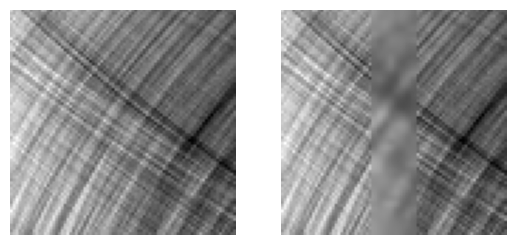

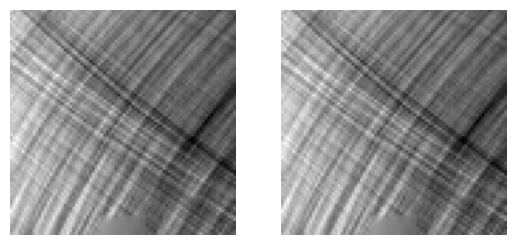

In [15]:
with torch.no_grad() :
    generator.eval()
    discriminator.eval()
    refImages[1,...,DCfg.gapRngX] = generator.preProc(refImages[1,...])
    mgens = generator.generateImages(refImages,refNoises)
    liks = discriminator(torch.cat((refImages, mgens[0,...].unsqueeze(0))))
    print(liks.detach().cpu().squeeze().numpy())
    tensorStat( mgens[1,*DCfg.disRng] - refImages[1,*DCfg.disRng] )
    plotImages((refImages[0,...].detach().cpu().squeeze(),
                refImages[1,...].detach().cpu().squeeze()))
    plotImages((mgens[0,...].detach().cpu().squeeze(),
                mgens[1,...].detach().cpu().squeeze()))


## <font style="color:lightblue">Train</font>

### <font style="color:lightblue">Metrics</font>

In [16]:
BCE = nn.BCELoss(reduction='none')
MSE = nn.MSELoss(reduction='none')


def applyWeights(inp, weights):
    inp = inp.squeeze()
    sum = len(inp)
    if not weights is None :
        inp *= weights
        sum = weights.sum()
    return inp.sum()/sum

def loss_Adv(y_true, y_pred, weights=None):
    loss = BCE(y_pred, y_true)
    return applyWeights(loss,weights)

TrainInfoMaxDifIdx = 0
def loss_Gen(y_true, y_pred, p_true, p_pred, weights=None):
    global TrainInfoMaxDifIdx
    lossAdv = loss_Adv(y_true, y_pred, weights)
    lossesDif = MSE(p_pred, p_true).mean(dim=(1,2))
    TrainInfoMaxDifIdx = lossesDif.argmax().item()
    lossDif = applyWeights(lossesDif, weights)
    return lossAdv, lossDif

lossDifCoef = 0


def summarizeSet(dataloader, prepOnly=False):

    D_losses, GA_fakeLosses, GD_fakeLosses, GA_prepLosses, GD_prepLosses = [], [], [], [], []
    ratReal = ratPrep = ratFake = nofIm = 0
    with torch.no_grad():
        generator.eval()
        discriminator.eval()
        for it , data in tqdm.tqdm(enumerate(dataloader), total=int(len(dataloader))):

            images = data[0].squeeze(1).to(TCfg.device)
            nofIm = images.shape[0]
            labelsTrue = torch.full((nofIm, 1),  1 - TCfg.labelSmoothFac,
                                dtype=torch.float, device=TCfg.device)
            nofIm += images.shape[0]

            if prepOnly :
                prepImages = images.clone()
                prepImages[...,*DCfg.gapRng] = generator.preProc(images)
                GA_loss_prep, GD_loss_prep = \
                    loss_Gen(labelsTrue, labelsTrue,
                             images[...,DCfg.gapRngX], prepImages[...,DCfg.gapRngX])
                GD_prepLosses.append(GD_loss_prep)

            else :

                y_pred_real = discriminator(images)
                D_loss_real = loss_Adv(labelsTrue, y_pred_real)
                D_losses.append(D_loss_real)
                ratReal += torch.count_nonzero(y_pred_real > 0.5)

                prepImages = images.clone()
                prepImages[...,*DCfg.gapRng] = generator.preProc(images)
                y_pred_prep = discriminator(prepImages)
                GA_loss_prep, GD_loss_prep = \
                    loss_Gen(labelsTrue, y_pred_prep,
                             images[...,DCfg.gapRngX], prepImages[...,DCfg.gapRngX])
                GA_prepLosses.append(GA_loss_prep)
                GD_prepLosses.append(GD_loss_prep)
                ratPrep += torch.count_nonzero(y_pred_prep > 0.5)

                fakeImages = generator.generateImages(images)
                y_pred_fake = discriminator(fakeImages)
                GA_loss_fake, GD_loss_fake = \
                    loss_Gen(labelsTrue, y_pred_fake,
                             images[...,DCfg.gapRngX], fakeImages[...,DCfg.gapRngX])
                GA_fakeLosses.append(GA_loss_fake)
                GD_fakeLosses.append(GD_loss_fake)
                ratFake += torch.count_nonzero(y_pred_fake > 0.5)


    total_GD_loss_prep = statistics.fmean(GD_prepLosses)
    if prepOnly :
        print(f"Prep MSE: {total_GD_loss_prep:.4e}.")
    else :
        total_D_loss = statistics.fmean(D_losses)
        total_GA_loss_prep = statistics.fmean(GA_prepLosses)
        total_GA_loss_fake = statistics.fmean(GA_fakeLosses)
        total_GD_loss_fake = statistics.fmean(GD_fakeLosses)
        print(f"Dis {total_D_loss:.4e} ({ratReal/len(dataloader)}),\n"
              f"Pre {total_GA_loss_prep:.4e} + {total_GD_loss_prep:.4e} ({ratPrep/nofIm}),\n"
              f"Gen {total_GA_loss_fake:.4e} + {total_GD_loss_fake:.4e} ({ratFake/nofIm})."
             )
    return total_GD_loss_prep



### <font style="color:lightblue">Train step</font>

In [17]:

#torch.autograd.set_detect_anomaly(True)


class TrainInfo:
    bestRealImage = None
    bestRealPrediction = 0
    bestRealIndex = 0
    worstRealImage = None
    worstRealPrediction = 0
    worstRealIndex = 0
    bestFakeImage = None
    bestFakePrediction = 0
    bestFakeIndex = 0
    worstFakeImage = None
    worstFakePrediction = 0
    worstFakeIndex = 0
    highestDifIndex = 0
    ratReal = 0.0
    ratFake = 0.0
    totalImages = 0
    iterations = 0
    disPerformed = 0
    genPerformed = 0


trainDis = True
trainGen = True
def train_step(images):
    global trainDis, trainGen
    TrainInfo.iterations += 1

    nofIm = images.shape[0]
    images = images.squeeze(1).to(TCfg.device)
    labelsTrue = torch.full((nofIm, 1),  1 - TCfg.labelSmoothFac,
                        dtype=torch.float, device=TCfg.device)
    labelsFalse = torch.full((nofIm, 1),  TCfg.labelSmoothFac,
                        dtype=torch.float, device=TCfg.device)


    fakeImages = None
    y_pred_real = None
    y_pred_fake = None
    y_pred_both = None
    labels = None
    D_loss = None
    G_loss = None
    GA_loss = None
    GD_loss = None
    dif_losses = None

    ratReal = 0
    ratFake = 0

    generator.eval()
    discriminator.train()
    counter = 0
    if trainDis:
        counter += 1
        TrainInfo.disPerformed += 1
        try :
            optimizer_D.zero_grad()

            y_pred_real = discriminator(images)
            fakeImages = generator.generateImages(images)
            y_pred_fake = discriminator(fakeImages)

            y_pred_both = torch.cat((y_pred_real, y_pred_fake), dim=0)
            labels = torch.cat( (labelsTrue, labelsFalse), dim=0).to(TCfg.device)
            D_loss = loss_Adv(labels, y_pred_both)

            #preImages = images.clone()
            #preImages[...,*DCfg.gapRng] = generator.preProc(images)
            #y_pred_pre = discriminator(preImages)
            #y_pred_fake = y_pred_pre
            #y_pred_both = torch.cat((y_pred_real, y_pred_pre), dim=0)
            #labels = torch.cat( (labelsTrue, labelsFalse), dim=0).to(TCfg.device)
            #D_loss = loss_Adv(labels, y_pred_both, torch.cat( (weights, weights) ) )

            #preImages = images.clone()
            #preImages[...,*DCfg.gapRng] = generator.preProc(images)
            #y_pred_pre = discriminator(preImages)
            #y_pred_both = torch.cat((y_pred_real, y_pred_real,
            #                         y_pred_fake, y_pred_pre), dim=0)
            #labels = torch.cat( (labelsTrue, labelsTrue,
            #                     labelsFalse, labelsFalse), dim=0).to(TCfg.device)
            #D_loss = loss_Adv(labels, y_pred_both, torch.cat( (weights, weights,
            #                                                   weights, weights) ) )

            D_loss.backward()
            optimizer_D.step()
        except :
            optimizer_D.zero_grad()
            del fakeImages
            del y_pred_real
            del y_pred_fake
            del y_pred_both
            del labels
            del D_loss
            raise
        ratReal = torch.count_nonzero(y_pred_real > 0.5)/nofIm
        ratFake = torch.count_nonzero(y_pred_fake > 0.5)/nofIm
        #trainGen = ratReal > ratFake
    else :
        with torch.no_grad():
            y_pred_real = discriminator(images)
            D_loss = loss_Adv(labelsTrue, y_pred_real)
            ratReal = torch.count_nonzero(y_pred_real > 0.5)/nofIm


    discriminator.eval()
    generator.train()
    counter = 0
    if trainGen :
        counter += 1
        TrainInfo.genPerformed += 1
        try :
            optimizer_G.zero_grad()
            fakeImages = generator.generateImages(images)
            y_pred_fake = discriminator(fakeImages)
            GA_loss, GD_loss = loss_Gen(labelsTrue, y_pred_fake,
                                        images[...,DCfg.gapRngX], fakeImages[...,DCfg.gapRngX])
            G_loss = GA_loss + lossDifCoef * GD_loss
            G_loss.backward()
            optimizer_G.step()
        except :
            optimizer_G.zero_grad()
            del fakeImages
            del y_pred_fake
            del G_loss
            del GA_loss
            del GD_loss
            del dif_losses
        ratFake = torch.count_nonzero(y_pred_fake > 0.5)/nofIm
        #trainDis = True # ratFake > 0.1 or ratReal <= ratFake
    else :
        with torch.no_grad():
            GA_loss, GD_loss = loss_Gen(labelsTrue, y_pred_fake,
                                        images[...,DCfg.gapRngX], fakeImages[...,DCfg.gapRngX])
            G_loss = GA_loss + lossDifCoef * GD_loss
            ratFake = torch.count_nonzero(y_pred_fake > 0.5)/nofIm

    #trainDis = trainGen = True


    idx = y_pred_real.argmax()
    TrainInfo.bestRealImage = images[idx,...].clone().detach()
    TrainInfo.bestRealPrediction = y_pred_real[idx].item()
    TrainInfo.bestRealIndex = idx

    idx = y_pred_real.argmin()
    TrainInfo.worstRealImage = images[idx,...].clone().detach()
    TrainInfo.worstRealPrediction =  y_pred_real[idx].item()
    TrainInfo.worstRealIndex = idx

    idx = y_pred_fake.argmax()
    TrainInfo.bestFakeImage = fakeImages[idx,...].clone().detach()
    TrainInfo.bestFakePrediction = y_pred_fake[idx].item()
    TrainInfo.bestFakeIndex = idx

    idx = y_pred_fake.argmin()
    TrainInfo.worstFakeImage = fakeImages[idx,...].clone().detach()
    TrainInfo.worstFakePrediction = y_pred_fake[idx].item()
    TrainInfo.worstFakeIndex = idx

    TrainInfo.highestDifIndex = TrainInfoMaxDifIdx
    TrainInfo.ratReal += ratReal * nofIm
    TrainInfo.ratFake += ratFake * nofIm
    TrainInfo.totalImages += nofIm

    return D_loss, GA_loss, GD_loss



### <font style="color:lightblue">Trainer</font>

In [18]:


D_LOSS = []
GA_LOSS = []
GD_LOSS = []



def train(dataloader):
    global epoch, minGdLoss, minGEpoch, prepGdLoss
    lastGdLoss = minGdLoss

    discriminator.to(TCfg.device)
    generator.to(TCfg.device)
    refImages.to(TCfg.device)
    refNoises.to(TCfg.device)
    lastUpdateTime = time.time()

    while True:
        epoch += 1

        generator.train()
        discriminator.train()
        D_loss_list, GA_loss_list, GD_loss_list = [], [], []

        for it , data in tqdm.tqdm(enumerate(dataloader), total=int(len(dataloader))):
            images = data[0].to(TCfg.device)
            D_loss, GA_loss, GD_loss = train_step(images)
            #print(f" Dis {D_loss.item():.3f}, Gen {GA_loss.item():.3f}, MSE {GD_loss.item():.3f}.")
            D_loss_list.append(D_loss)
            GA_loss_list.append(GA_loss)
            GD_loss_list.append(GD_loss)

            #if True:
            #if not it or it > len(dataloader)-2 or time.time() - lastUpdateTime > 60 :
            if time.time() - lastUpdateTime > 60 :
                lastUpdateTime = time.time()
                IPython.display.clear_output(wait=True)
                print(f"Epoch: {epoch} ({minGEpoch}). Losses: "
                      f" Dis: {D_loss:.3f} "
                      f"({TrainInfo.ratReal/TrainInfo.totalImages:.3f} / "
                      f"{TrainInfo.disPerformed/TrainInfo.iterations:.3f}),"
                      f" Gen: {GA_loss:.3f} "
                      f"({TrainInfo.ratFake/TrainInfo.totalImages:.3f} / "
                      f"{TrainInfo.genPerformed/TrainInfo.iterations:.3f}),"
                      f" MSE: {lastGdLoss:.3e} ({minGdLoss:.3e} / {prepGdLoss:.3e})."
                      )
                TrainInfo.iterations = 0
                TrainInfo.totalImages = 0
                TrainInfo.ratReal = 0
                TrainInfo.ratFake = 0
                TrainInfo.genPerformed = 0
                TrainInfo.disPerformed = 0

                liks = None
                with torch.inference_mode() :
                    #iM = trainSet[random.randint(0,len(trainSet)-1)][0].clone().detach().to(TCfg.device)
                    #iM = images[TrainInfo.highestDifIndex,0,...].clone().detach().unsqueeze(0)
                    iM = refImages[0,...].unsqueeze(0)
                    hdIms = torch.repeat_interleave(iM,3,dim=0)
                    dif = torch.zeros(DCfg.sinoSh)
                    hGap = DCfg.gapW // 2
                    generator.eval()
                    org = hdIms[0,...]
                    pre = generator.preProc(org)
                    hdIms[2,*DCfg.gapRng] = pre
                    gen = generator.generatePatches(org)
                    hdIms[1,*DCfg.gapRng] = gen
                    discriminator.eval()
                    liks = discriminator(hdIms)
                    dif[DCfg.gapRng] = gen - pre
                    dif[:,hGap:hGap+DCfg.gapW] = org[DCfg.gapRng] - pre
                    dif[:,-DCfg.gapW-hGap:-hGap] = org[DCfg.gapRng] - gen
                    if ( cof := max(-dif.min(),dif.max()) ) != 0 :
                        dif /= 2*cof

                fourImages = np.zeros( (2*DCfg.sinoSh[1] + DCfg.gapW ,
                                       4*DCfg.sinoSh[0] + 3*DCfg.gapW), dtype=np.float32  )
                def addImage(clmn, row, img, stretch=True) :
                    minv = img.min().item()
                    maxv = img.max().item()
                    nimg =  img if not stretch \
                        else ( img - minv ) / ( maxv - minv ) - 0.5 if minv != maxv \
                            else torch.zeros_like(img)
                    fourImages[ row * ( DCfg.sinoSh[1]+DCfg.gapW) : (row+1) * DCfg.sinoSh[1] + row*DCfg.gapW ,
                                clmn * ( DCfg.sinoSh[0]+DCfg.gapW) : (clmn+1) * DCfg.sinoSh[0] + clmn*DCfg.gapW ] = \
                        nimg.squeeze().detach().cpu().numpy()

                addImage(0,0,TrainInfo.bestRealImage)
                addImage(0,1,TrainInfo.worstRealImage)
                addImage(1,0,TrainInfo.bestFakeImage)
                addImage(1,1,TrainInfo.worstFakeImage)
                addImage(2,0,hdIms[1,...])
                addImage(2,1,hdIms[0,...])
                addImage(3,0,hdIms[2,...])
                addImage(3,1,dif,False)

                print (f"TT: {TrainInfo.bestRealPrediction:.4e} ({data[1][TrainInfo.bestRealIndex]},{data[2][TrainInfo.bestRealIndex]}),  "
                       f"FT: {TrainInfo.bestFakePrediction:.4e} ({data[1][TrainInfo.bestFakeIndex]},{data[2][TrainInfo.bestFakeIndex]}),  "
                       f"GP: {liks[1].item():.5f}, {liks[2].item():.5f} " )
                print (f"TF: {TrainInfo.worstRealPrediction:.4e} ({data[1][TrainInfo.worstRealIndex]},{data[2][TrainInfo.worstRealIndex]}),  "
                       f"FF: {TrainInfo.worstFakePrediction:.4e} ({data[1][TrainInfo.worstFakeIndex]},{data[2][TrainInfo.worstFakeIndex]}),  "
                       f"R : {liks[0].item():.5f} ({data[1][TrainInfo.highestDifIndex]},{data[2][TrainInfo.highestDifIndex]})" )
                try :
                    #tifffile.imwrite(f"tmp_{TCfg.exec}.tif", fourImages)
                    addToHDF(TCfg.historyHDF, "data", fourImages)
                except :
                    eprint("Failed to save.")
                plotImage(fourImages)

        epoch_D_loss = sum(D_loss_list)/len(D_loss_list)
        epoch_GA_loss = sum(GA_loss_list)/len(GA_loss_list)
        epoch_GD_loss = sum(GD_loss_list)/len(GD_loss_list)
        lastGdLoss = epoch_GD_loss
        D_LOSS.append(epoch_D_loss.detach().cpu())
        GA_LOSS.append(epoch_GA_loss.detach().cpu())
        GD_LOSS.append(epoch_GD_loss.detach().cpu())
        if minGdLoss < 0.0 or ( epoch_GD_loss < minGdLoss and epoch_D_loss < 0.695) :
            minGdLoss = epoch_GD_loss
            minGEpoch = epoch
            saveCheckPoint(savedCheckPoint+"_BEST.pth",
                           epoch, minGEpoch, minGdLoss,
                           generator, discriminator,
                           optimizer_G, optimizer_D,
                           device=TCfg.device)
            os.system(f"cp {savedCheckPoint}.pth {savedCheckPoint}_BeforeBest.pth")
            os.system(f"cp {savedCheckPoint}_BEST.pth {savedCheckPoint}.pth")
        else :
            saveCheckPoint(savedCheckPoint+".pth",
                           epoch, minGEpoch, minGdLoss,
                           generator, discriminator,
                           optimizer_G, optimizer_D,
                           device=TCfg.device)


## <font style="color:lightblue">Execute</font>

Epoch: 115 (114). Losses:  Dis: 0.637 (0.595 / 1.000), Gen: 0.869 (0.222 / 1.000), MSE: 4.725e-03 (4.725e-03 / 5.373e-03).
TT: 9.8339e-01 (5037973,226),  FT: 8.1131e-01 (2928718,2733),  GP: 0.45296, 0.42320 
TF: 1.2611e-01 (3501043,689),  FF: 4.9664e-02 (3457935,3029),  R : 0.73600 (3957637,1506)


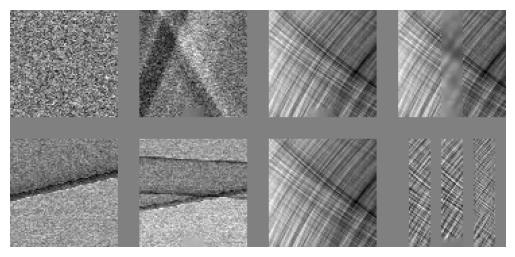

 89%|████████▉ | 9083/10194 [8:40:14<1:07:41,  3.66s/it]

In [ ]:
#for item in itertools.chain( optimizer_D.param_groups, optimizer_G.param_groups ):
#    item['lr'] *= 0.1

trainLoader = torch.utils.data.DataLoader(
    dataset=trainSet,
    batch_size=TCfg.batchSize,
    shuffle=False,
    num_workers=os.cpu_count()
)
prepGdLoss = 5.3729e-03
if prepGdLoss == 0:
    prepGdLoss = summarizeSet(trainLoader, True)


# weight of the MSE loss in generator metrics. Initially set to 0 to repel training from trivial solution of
# zero correction,and later set to higher number when pure adversarial loss makes generator to produce results
# superior to zero correction.
lossDifCoef = 1000
trainGen=True
trainDis=True
minGdLoss = prepGdLoss
try :
    #summarizeSet(trainLoader)
    train(trainLoader)
except :
    del trainLoader
    raise

## <font style="color:lightblue">Post</font>

1815790 488
1.815192035792279e-06
[0.17419602 0.07628525 0.00266389]


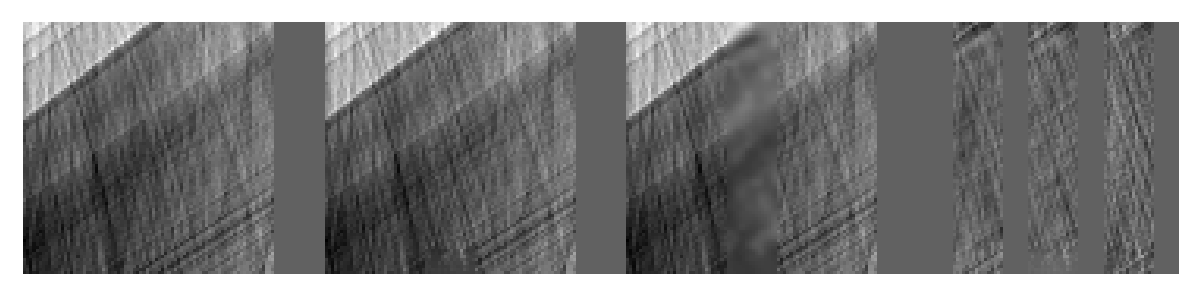

In [ ]:
generator.eval()
discriminator.eval()

def testMe() :
    with torch.no_grad() :

        testImage, index, idxs = trainSet[random.randint(0,len(trainSet)-1)] # (1881919,513)
        print(index, idxs)
        testImage = testImage.to(TCfg.device)
        preImage = testImage.clone()
        patch = generator.preProc(testImage)
        preImage[:,*DCfg.gapRng] = patch
        genImage = generator.generateImages(testImage)
        mse = MSE(testImage, genImage).mean().item()
        print(mse)

        toShow = np.zeros( ( DCfg.sinoSh[1], 4*DCfg.sinoSh[0] + 3*DCfg.gapW), dtype=np.float32  )
        def addImage(clmn, img) :
            toShow[ :  , clmn * ( DCfg.sinoSh[0]+DCfg.gapW) : (clmn+1) * DCfg.sinoSh[0] + clmn*DCfg.gapW ] = \
                img.squeeze().detach().cpu().numpy()

        mn = testImage.mean().item()
        addImage(0, testImage - mn)
        addImage(1, genImage - mn)
        addImage(2, preImage - mn)
        dif = genImage - preImage
        hGap = DCfg.gapW // 2
        dif[:,:,hGap:hGap+DCfg.gapW] = (testImage[:,*DCfg.gapRng] - preImage[:,*DCfg.gapRng])
        dif[:,:,-DCfg.gapW-hGap:-hGap] = (genImage[:,*DCfg.gapRng] - testImage[:,*DCfg.gapRng])
        #if ( cof := max(-dif.min(),dif.max()) ) != 0 :
        #    dif /= 2*cof
        addImage(3, dif)
        disIn = torch.cat(( testImage, genImage, preImage), dim=0)
        liks = discriminator(disIn)
        print(liks.squeeze().cpu().numpy())
        plotImage(toShow)


testMe()


In [ ]:
if True :
    save_model(generator, TCfg.device, model_path=f"model_{TCfg.exec}_gen.pt")
    save_model(discriminator, TCfg.device, model_path=f"model_{TCfg.exec}_dis.pt")